In [17]:
!pip install kagglehub


Defaulting to user installation because normal site-packages is not writeable


In [18]:
import pandas as pd
import numpy as np
import os

import kagglehub
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path:", path)

# Load CSV
df = pd.read_csv(os.path.join(path, "creditcard.csv"))

df.head()
df.shape
df.info()
df.isnull().sum()
df['Class'].value_counts()
df['Class'].value_counts(normalize=True)

Path: /home/fena/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [19]:
from sklearn.model_selection import train_test_split

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (199364, 30)
Test shape: (85443, 30)


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline_model = LogisticRegression(max_iter=2000)

baseline_model.fit(X_train_scaled, y_train)

y_pred = baseline_model.predict(X_test_scaled)
y_prob = baseline_model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

KeyboardInterrupt: 

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X_train_scaled)

# Plot cumulative explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

In [ ]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original features:", X_train.shape[1])
print("Reduced features:", X_train_pca.shape[1])

In [ ]:
pca_model = LogisticRegression(max_iter=2000)
pca_model.fit(X_train_pca, y_train)

y_pred_pca = pca_model.predict(X_test_pca)
y_prob_pca = pca_model.predict_proba(X_test_pca)[:, 1]

print(classification_report(y_test, y_pred_pca))
print("ROC-AUC (PCA):", roc_auc_score(y_test, y_prob_pca))

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF

scaler_nmf = MinMaxScaler()

X_train_minmax = scaler_nmf.fit_transform(X_train)
X_test_minmax = scaler_nmf.transform(X_test)
X_test_minmax = np.clip(X_test_minmax, 0, 1) 


In [23]:
nmf = NMF(n_components=20, random_state=42, max_iter=500)

X_train_nmf = nmf.fit_transform(X_train_minmax)
X_test_nmf = nmf.transform(X_test_minmax)


print("NMF features:", X_train_nmf.shape[1])

/home/fena/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


NMF features: 20


/home/fena/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [25]:
nmf_model = LogisticRegression(max_iter=2000)
nmf_model.fit(X_train_nmf, y_train)

y_pred_nmf = nmf_model.predict(X_test_nmf)
y_prob_nmf = nmf_model.predict_proba(X_test_nmf)[:, 1]

print(classification_report(y_test, y_pred_nmf))
print("ROC-AUC (NMF):", roc_auc_score(y_test, y_prob_nmf))

/home/fena/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fena/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC (NMF): 0.8707319430339537


/home/fena/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
results = {
    "Baseline ROC-AUC": roc_auc_score(y_test, y_prob),
    "PCA ROC-AUC": roc_auc_score(y_test, y_prob_pca),
    "NMF ROC-AUC": roc_auc_score(y_test, y_prob_nmf)
}

results

import pandas as pd

comparison_df = pd.DataFrame.from_dict(results, orient="index", columns=["ROC-AUC"])
comparison_df

,ROC-AUC
Baseline ROC-AUC,0.956719
PCA ROC-AUC,0.956775
NMF ROC-AUC,0.870732


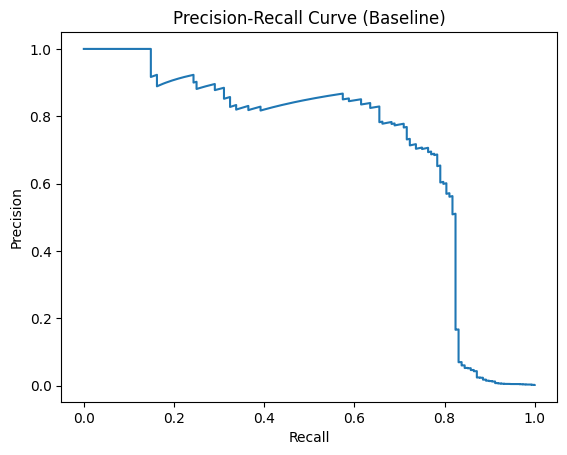

In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Baseline)")
plt.show()